In [ ]:
import torch
import torch.nn.functional as F
import timm
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import matplotlib as mpl

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load DINOv3 ViT-S/16
model = timm.create_model(
    "vit_small_patch16_224.dino",
    pretrained=False
)

checkpoint = torch.load("dinov3_vits16_pretrain_lvd1689m-08c60483.pth", map_location=device)
model.load_state_dict(checkpoint, strict=False)

model.eval().to(device)
print("Done")


Done


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    )
])

def load_image(path):
    img = Image.open(path).convert("RGB")
    tensor = transform(img).unsqueeze(0).to(device)
    return img, tensor


In [ ]:
def extract_patch_features(model, image_tensor):
    with torch.no_grad():
        output = model.forward_features(image_tensor)  # (1, 197, D)
        
        # Remove CLS token (first token)
        patch_tokens = output[:, 1:, :]  # (1, 196, D)

    return patch_tokens.squeeze(0)  # (196, D)


In [ ]:
img1_pil, img1_tensor = load_image("wheelstopper.jpeg")
img2_pil, img2_tensor = load_image("ws1.jpeg")
print("img1_tensor shape:", img1_tensor.shape)  # (1, 3, 224, 224)
features1 = extract_patch_features(model, img1_tensor)  # (196, D)
features2 = extract_patch_features(model, img2_tensor)  # (196, D)


img1_tensor shape: torch.Size([1, 3, 224, 224])


In [ ]:
object_embedding = features2.mean(dim=0, keepdim=True)  # (1, D)

In [ ]:
# Normalize
features1 = F.normalize(features1, dim=1)
object_embedding = F.normalize(object_embedding, dim=1)

# Cosine similarity
similarity = torch.matmul(features1, object_embedding.T)  # (196, 1)
similarity = similarity.squeeze(1)


In [ ]:
sim_map = similarity.reshape(14, 14).cpu().numpy()

# Normalize for visualization
sim_map = (sim_map - sim_map.min()) / (sim_map.max() - sim_map.min())


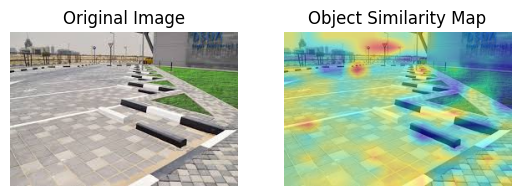

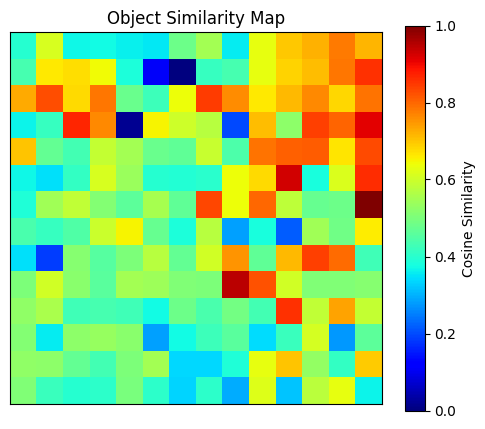

In [ ]:
# Resize heatmap to original size
heatmap = cv2.resize(sim_map, img1_pil.size)
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

img1_np = np.array(img1_pil)
overlay = cv2.addWeighted(img1_np, 0.6, heatmap, 0.4, 0)

plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.title("Original Image")
plt.imshow(img1_np)
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Object Similarity Map")
plt.imshow(overlay)
plt.axis("off")
plt.show()

plt.figure(figsize=(6,5))

im = plt.imshow(sim_map, cmap='jet', vmin=0, vmax=1)
plt.colorbar(im, label="Cosine Similarity")

plt.title("Object Similarity Map")
plt.xticks([])
plt.yticks([])

plt.show()



✅ Model Loaded Successfully


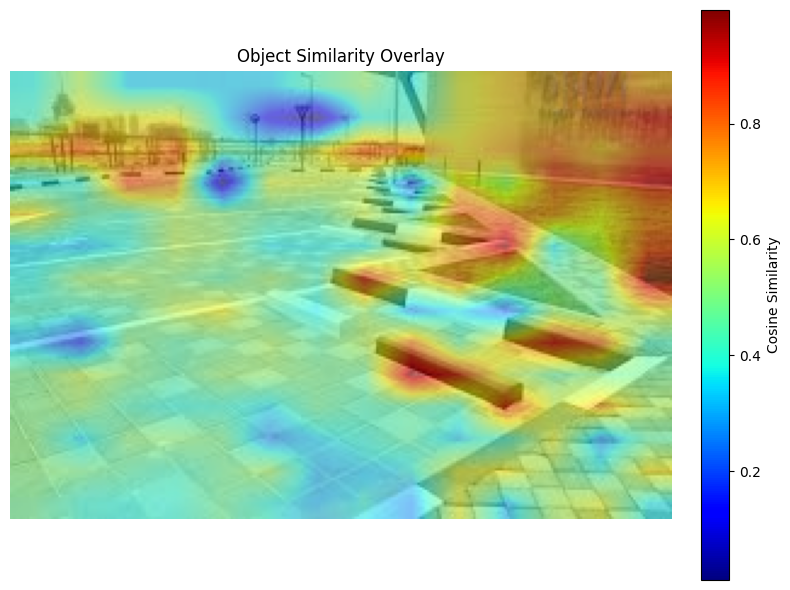

In [ ]:
import torch
import torch.nn.functional as F
import timm
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"

# -------------------------------------------------------
# 1️⃣ Load DINOv3 (offline)
# -------------------------------------------------------
def load_dino_model(model_path, device):
    model = timm.create_model(
        "vit_small_patch16_224",
        pretrained=False,
        num_classes=0
    )

    checkpoint = torch.load(model_path, map_location=device)

    if "model" in checkpoint:
        state_dict = checkpoint["model"]
    elif "state_dict" in checkpoint:
        state_dict = checkpoint["state_dict"]
    else:
        state_dict = checkpoint

    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith("module."):
            k = k.replace("module.", "")
        if k.startswith("backbone."):
            k = k.replace("backbone.", "")
        new_state_dict[k] = v

    model.load_state_dict(new_state_dict, strict=False)
    model.eval().to(device)

    print("✅ Model Loaded Successfully")
    return model


# -------------------------------------------------------
# 2️⃣ Image Preprocessing
# -------------------------------------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    )
])

def load_image(path):
    img = Image.open(path).convert("RGB")
    tensor = transform(img).unsqueeze(0).to(device)
    return img, tensor


# -------------------------------------------------------
# 3️⃣ Extract Patch Features
# -------------------------------------------------------
def extract_patch_features(model, image_tensor):
    with torch.no_grad():
        x = model.forward_features(image_tensor)  # (1, 197, D)
        patch_tokens = x[:, 1:, :]                # remove CLS
    return patch_tokens.squeeze(0)                # (196, D)


# -------------------------------------------------------
# 4️⃣ Create Object Embedding (Top-K Patches)
# -------------------------------------------------------
def create_object_embedding(features2, k=10):
    features2 = F.normalize(features2, dim=1)

    norms = features2.norm(dim=1)
    topk_idx = torch.topk(norms, k=k).indices

    object_embedding = features2[topk_idx].mean(dim=0, keepdim=True)
    object_embedding = F.normalize(object_embedding, dim=1)

    return object_embedding


# -------------------------------------------------------
# 5️⃣ Compute Similarity Map
# -------------------------------------------------------
def compute_similarity_map(features1, object_embedding):
    features1 = F.normalize(features1, dim=1)

    similarity = torch.matmul(features1, object_embedding.T)
    similarity = similarity.squeeze(1)

    sim_map = similarity.reshape(14, 14).cpu().numpy()

    # Normalize for visualization
    sim_map = (sim_map - sim_map.min()) / (sim_map.max() - sim_map.min() + 1e-8)

    return sim_map


# -------------------------------------------------------
# 6️⃣ Extract Bounding Box
# -------------------------------------------------------
def extract_bounding_box(sim_map, threshold=0.75):
    mask = sim_map > threshold

    if mask.sum() == 0:
        return None

    coords = np.column_stack(np.where(mask))

    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)

    return x_min, y_min, x_max, y_max


# -------------------------------------------------------
# 7️⃣ Visualization
# -------------------------------------------------------
def visualize_results(img1_pil, sim_map, alpha=0.5):
    img_np = np.array(img1_pil)

    # Resize similarity map to original resolution
    sim_resized = cv2.resize(sim_map, (img_np.shape[1], img_np.shape[0]))

    # Convert similarity to 0–255
    heatmap = np.uint8(255 * sim_resized)

    # Apply colormap
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Convert BGR (OpenCV) → RGB
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

    # Overlay
    overlay = cv2.addWeighted(img_np, 1 - alpha, heatmap_color, alpha, 0)

    # Plot
    plt.figure(figsize=(8,6))

    im = plt.imshow(overlay)
    plt.title("Object Similarity Overlay")
    plt.axis("off")

    # Add colorbar based on similarity map
    sm = plt.cm.ScalarMappable(cmap='jet')
    sm.set_array(sim_resized)
    sm.set_clim(vmin=0, vmax=1)
    plt.colorbar(sm, fraction=0.046, pad=0.04, label="Cosine Similarity")

    plt.tight_layout()
    plt.show()

def visualize_overlay_with_colorbar(img1_pil, sim_map, alpha=0.5):
    img_np = np.array(img1_pil)

    # Resize similarity map
    sim_resized = cv2.resize(sim_map, (img_np.shape[1], img_np.shape[0]))

    # Normalize explicitly (0–1)
    sim_min = sim_resized.min()
    sim_max = sim_resized.max()
    sim_norm = (sim_resized - sim_min) / (sim_max - sim_min + 1e-8)

    # Create heatmap using matplotlib colormap
    cmap = plt.cm.jet
    heatmap = cmap(sim_norm)[:, :, :3]   # remove alpha channel
    heatmap = (heatmap * 255).astype(np.uint8)

    # Overlay
    overlay = cv2.addWeighted(img_np, 1 - alpha, heatmap, alpha, 0)

    # Plot
    fig, ax = plt.subplots(figsize=(8,6))
    ax.imshow(overlay)
    ax.axis("off")
    ax.set_title("Object Similarity Overlay")

    # Create proper ScalarMappable for colorbar
    norm = mpl.colors.Normalize(vmin=sim_min, vmax=sim_max)
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    cbar = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Cosine Similarity")

    plt.tight_layout()
    plt.show()

def visualize_full_result(img1_pil, img2_pil, sim_map, alpha=0.5):
    img1_np = np.array(img1_pil)
    img2_np = np.array(img2_pil)

    # Resize similarity map to image1 size
    sim_resized = cv2.resize(sim_map, (img1_np.shape[1], img1_np.shape[0]))

    # Normalize similarity (0–1)
    sim_min = sim_resized.min()
    sim_max = sim_resized.max()
    sim_norm = (sim_resized - sim_min) / (sim_max - sim_min + 1e-8)

    # Create heatmap
    cmap = plt.cm.jet
    heatmap = cmap(sim_norm)[:, :, :3]
    heatmap = (heatmap * 255).astype(np.uint8)

    # Overlay
    overlay = cv2.addWeighted(img1_np, 1 - alpha, heatmap, alpha, 0)

    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=(16,6))

    # Image 1
    axes[0].imshow(img1_np)
    axes[0].set_title("Image 1 (Scene)")
    axes[0].axis("off")

    # Image 2
    axes[1].imshow(img2_np)
    axes[1].set_title("Image 2 (Query Object)")
    axes[1].axis("off")

    # Result Overlay
    im = axes[2].imshow(overlay)
    axes[2].set_title("Similarity Overlay")
    axes[2].axis("off")

    # Proper colorbar
    norm = mpl.colors.Normalize(vmin=sim_min, vmax=sim_max)
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    cbar = fig.colorbar(sm, ax=axes[2], fraction=0.046, pad=0.04)
    cbar.set_label("Cosine Similarity")

    plt.tight_layout()
    plt.show()



# -------------------------------------------------------
# 8️⃣ RUN PIPELINE
# -------------------------------------------------------
model_path = "dinov3_vits16_pretrain_lvd1689m-08c60483.pth"
image1_path = "wheelstopper.jpeg"   # multi-object image
image2_path = "ws1.jpeg"            # object image

# image1_path = "fruits1.jpg"   # multi-object image
# image2_path = "bg1.jpg"            # object image

model = load_dino_model(model_path, device)

img1_pil, img1_tensor = load_image(image1_path)
img2_pil, img2_tensor = load_image(image2_path)

features1 = extract_patch_features(model, img1_tensor)
features2 = extract_patch_features(model, img2_tensor)

object_embedding = create_object_embedding(features2, k=10)

sim_map = compute_similarity_map(features1, object_embedding)

# bbox = extract_bounding_box(sim_map, threshold=0.75)
sim_map = compute_similarity_map(features1, object_embedding)


# visualize_results(img1_pil, sim_map, alpha=0.5)
visualize_overlay_with_colorbar(img1_pil, sim_map, alpha=0.5)

